## emupy worked example with simulation data from 21cmFAST

**Nick Kern**
<br>
**June, 2017**

---

Here we will create interpolation functions (an emulator) for the spherically-averaged 21cm brightness temperature power spectrum $P_{21}(k,z)$. The data itself are actually in the units $\Delta^{2}_{21}(k,z) = P_{21}(k,z)k^{3}/(2\pi^{2})\ [\rm{mK}^{2}]$. The data in `lh_training.pkl` are drawn from a random Latin-Hypercube design in a **three dimensional** model parameter space of the UV ionizing efficiency parameter ($\zeta$), the virial temperature of star-forming halos ($T_{vir}^{min}$), and the mean-free path of ionizing photons through ionized regions ($R_{mfp}$). See [Kern et al. 2017](https://arxiv.org/abs/1705.04688) for parameterization details. The data in `cross_inspection.pkl` are drawn from a uniform grid across each individual parameter while holding all others constant. 

The example below has certain code dependencies. See [emupy](github.com/nkern/emupy) for dependency details and installation instructions. Note that emupy, and by extension this example, is only supported for Python 2.7.

In [1]:
# Import modules
%matplotlib inline
import numpy as np
import emupy
import cPickle as pkl
import sklearn.gaussian_process as gp
import astropy.stats as astats
import matplotlib.pyplot as mp

In [10]:
# Load some training data
with open('lh_training.pkl','rb') as f:
    inp = pkl.Unpickler(f)
    dic = inp.load()
    data = dic['data']
    grid = dic['grid']
    
# Load cross-data
with open('cross_inspection.pkl','rb') as f:
    inp = pkl.Unpickler(f)
    dic = inp.load()
    data_cr = dic['data']
    grid_cr = dic['grid']
    # Sort the cross_inspection data and split into three individual data sets
    fid_grid = np.median(grid_cr, axis=0)
    sort1 = np.where((grid_cr.T[1]==fid_grid[1])&(grid_cr.T[2]==fid_grid[2]))[0]
    sort2 = np.where((grid_cr.T[0]==fid_grid[0])&(grid_cr.T[2]==fid_grid[2]))[0]
    sort3 = np.where((grid_cr.T[0]==fid_grid[0])&(grid_cr.T[1]==fid_grid[1]))[0]
    data_cr1, grid_cr1 = data_cr[sort1], grid_cr[sort1]
    data_cr2, grid_cr2 = data_cr[sort2], grid_cr[sort2]
    data_cr3, grid_cr3 = data_cr[sort3], grid_cr[sort3]
    
# Randomly select from data_tr and assign to cross-validation set data_cv
rng = np.random.RandomState(1)
rando = rng.choice(np.arange(len(data)), replace=False, size=150)
select = np.array(np.zeros(len(data)), dtype=bool)
select[rando] = True
data_tr = data[select]
grid_tr = grid[select]
data_cv = data[~select]
grid_cv = grid[~select]

# Load in k-data of power spectra
k_range = np.loadtxt('k_range.tab')
k_vals = np.array([k_range for i in range(3)]).ravel()
z_vals = np.array([np.arange(8,11) for i in range(11)]).T.ravel()
kz_info = np.array( zip(k_vals, z_vals))

`data_tr` is the array containing our training data y-values. It has shape `(200, 33)`, which corresponds to 200 individual samples within our 3-dimensional model space, each with 33 individual data elements of $\Delta^{2}_{21}$ that we want to emulate. The 33 elements of the data correspond to the power spectrum across 11 $k$ values found in `k_range` at redshifts $z = [8, 9, 10]$.

`grid_tr` is the array containing the training data x-values. It has shape `(200, 3)`, which corresponds to the 200 individual samples within our 3-dimensional model space, each with a unique vector position in the 3-d parameter space.

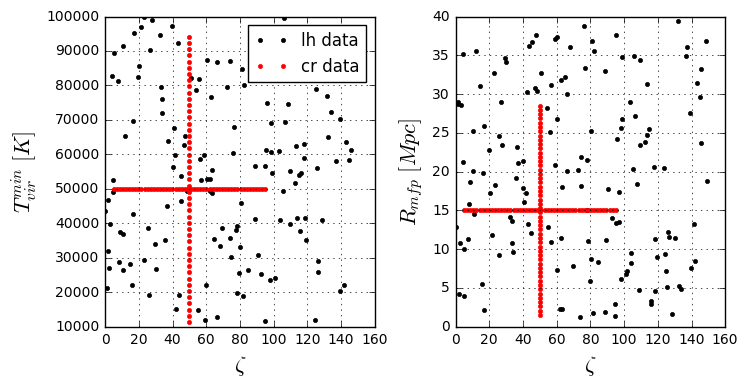

In [11]:
# Plot training data x-values
fig = mp.figure(figsize=(8,4))
fig.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(121)
ax.grid(True)
p0, = ax.plot(grid_tr.T[0], grid_tr.T[1], 'k.')
p1, = ax.plot(grid_cr1.T[0], grid_cr1.T[1], 'r.')
ax.plot(grid_cr2.T[0], grid_cr2.T[1], 'r.')
ax.set_xlabel('$\zeta$', fontsize=16)
ax.set_ylabel('$T_{vir}^{min}\ [{K}]$', fontsize=16)
ax.legend([p0,p1],['lh data', 'cr data'])

ax = fig.add_subplot(122)
ax.grid(True)
ax.plot(grid_tr.T[0], grid_tr.T[2], 'k.')
ax.plot(grid_cr1.T[0], grid_cr1.T[2], 'r.')
ax.plot(grid_cr3.T[0], grid_cr3.T[2], 'r.')
ax.set_xlabel('$\zeta$', fontsize=16)
ax.set_ylabel('$R_{mfp}\ [{Mpc}]$', fontsize=16)


In [12]:
# Initialize Emulator and its variables
# see help(E) for details on these parameters and their default values
E = emupy.Emu()

# Specify number of samples in training data
E.N_samples = len(data_tr)

# Specify number of model parameters
E.N_params = 3

# Specify number of data elements
E.N_data = len(data_tr.T)

# Specify usage of pca or not
E.use_pca = False

# If using pca, specify number of eigenmodes we want to keep during truncation
E.N_modes = 10

# Choose regression model for interpolation functions
E.reg_meth = 'gaussian'

# Choose to log normalize the data before taking covariance
E.lognorm = True

# Whiten the covariance matrix of the data before performing KLT
E.cov_whiten = False

In [13]:
# Calculate fiducial (or average) data properties
E.fid_data = np.median(data_tr, axis=0)
E.fid_grid = np.median(grid_tr, axis=0)

In [14]:
# Sphere training data x values
E.sphere(grid_tr, fid_grid=E.fid_grid, save_chol=True, norotate=True)

In [14]:
# Perform KLT to calculate eigenmodes
E.klt(data_tr, fid_data=E.fid_data, normalize=True)

In [15]:
## Setup Gaussian Process kwargs
# Setup a squared exponential kernel with diagonal noise hyperparameter
kernel = gp.kernels.RBF(length_scale=np.ones(E.N_params)) + gp.kernels.WhiteKernel(noise_level=1e-6)

# How many times to restart MLE search of hyperparameters
n_restarts_optimizer = 10

# Which optimizer to use
optimizer='fmin_l_bfgs_b'

# pack into a dictionary
gp_kwargs = {'kernel':kernel, 'n_restarts_optimizer':n_restarts_optimizer, 'optimizer':optimizer}
E.gp_kwargs = gp_kwargs

In [16]:
# Train Emulator
E.train(data_tr, grid_tr, fid_data=E.fid_data, fid_grid=E.fid_grid, verbose=True)

...finished modegroup #0
...finished modegroup #1
...finished modegroup #2
...finished modegroup #3
...finished modegroup #4
...finished modegroup #5
...finished modegroup #6
...finished modegroup #7
...finished modegroup #8
...finished modegroup #9
...finished modegroup #10
...finished modegroup #11
...finished modegroup #12
...finished modegroup #13
...finished modegroup #14
...finished modegroup #15
...finished modegroup #16
...finished modegroup #17
...finished modegroup #18
...finished modegroup #19
...finished modegroup #20
...finished modegroup #21
...finished modegroup #22
...finished modegroup #23
...finished modegroup #24
...finished modegroup #25
...finished modegroup #26
...finished modegroup #27
...finished modegroup #28
...finished modegroup #29
...finished modegroup #30
...finished modegroup #31
...finished modegroup #32


In [27]:
E.N_modegroups

33

In [20]:
cr1_pred_sph = np.dot(E.invL, (grid_cr1-E.fid_grid).T).T
E

In [19]:
# Make predictions across cross_inspection data x-values
cr1_pred = E.predict(grid_cr1, output=True)
cr2_pred = E.predict(grid_cr2, output=True)
cr3_pred = E.predict(grid_cr3, output=True)

# Choose which data to look at i = [0, 33]
i = 21

# Initialize figure
fig = mp.figure(figsize=(12,4))
fig.subplots_adjust(wspace=0.3)

# Look across zeta
ax=fig.add_subplot(131)
ax.grid(True)
p0, = ax.plot(grid_cr1.T[0], data_cr1.T[i], 'k.')
p1, = ax.plot(grid_cr1.T[0], cr1_pred[0].T[i])
ax.set_yscale('log')
ax.set_xlabel('$\zeta$', fontsize=16)
ax.set_ylabel('$\Delta^{2}_{21}\ [mK^{2}]$', fontsize=16)
ax.legend([p0, p1], ['true data', 'emulator fit'])

# Look across Tvir
ax=fig.add_subplot(132)
ax.grid(True)
ax.plot(grid_cr2.T[1], data_cr2.T[i], 'k.')
ax.plot(grid_cr2.T[1], cr2_pred[0].T[i])
[t.set_rotation(30) for t in ax.get_xticklabels()]
ax.set_yscale('log')
ax.set_xlabel('$T_{vir}^{min}$', fontsize=16)
ax.set_ylabel('$\Delta^{2}_{21}\ [mK^{2}]$', fontsize=16)
ax.annotate("$k = %0.2f\ Mpc^{-1}$" % kz_info[i][0], (0.05,0.9), xycoords='axes fraction')
ax.annotate("$z = %d$" % kz_info[i][1], (0.05,0.85), xycoords='axes fraction')

# Look across Rmfp
ax=fig.add_subplot(133)
ax.grid(True)
ax.plot(grid_cr3.T[2], data_cr3.T[i], 'k.')
ax.plot(grid_cr3.T[2], cr3_pred[0].T[i])
ax.set_yscale('log')
ax.set_xlabel('$R_{mfp}$', fontsize=16)
ax.set_ylabel('$\Delta^{2}_{21}\ [mK^{2}]$', fontsize=16)


IndexError: index 10 is out of bounds for axis 1 with size 10